In [18]:
import numpy as np
from numpy import eye, array, asarray
from numpy.linalg import inv
import matplotlib.pyplot as plt

In [19]:
class KalmanFilter:
    def __init__(self):
        self.M = None
        self.H = None
        self.mu = None
        self.Sigma = None
        self.Sigma_y = None
        self.Q = None
        
    def predict_response(self):
        return self.H @ self.mu
    
    # KF assimilation
    def update(self, y_t):
        # Predict y to measure innovation
        y_hat = self.predict_response()
        # Calculate Kalman gain
        K = self.Sigma @ self.H.T @ inv(self.H @ self.Sigma @ self.H.T + self.Sigma_y)
        # Update belief
        I = np.identity(self.mu.size)
        self.mu = self.mu + K @ (y_t - y_hat)
        self.Sigma = (I-K@self.H)@self.Sigma
    
    # time dynamics
    def predict(self):
        self.mu = self.M @ self.mu
        self.Sigma = self.M @ self.Sigma @ self.M.T + self.Q

In [20]:
# Initialize the Kalman Filter
kf = KalmanFilter()
# predict dynamics
dt = 1
kf.M = array([[1,dt],
      [0,1]])
kf.Q = eye(2)*0
# update dynamics
kf.H = array([
    [1,0]
])
# Create initial prior
kf.mu = array([[3],
                [4]])
kf.Sigma = array([
    [50,0],
    [0,50]
])
# noise of observations
kf.Sigma_y = None #added later

In [21]:
# Create observations
Sigma_y = array([[50,0],
                 [0,1]])
kf.Sigma_y = Sigma_y[0,0]

read_data = True
if read_data:
    pos_obs = np.loadtxt("car_position_observations.csv", delimiter=",")
    T = pos_obs.size
else:
    T = 30
    x_truth = [array([[50],[2]])]
    for t in range(1,T):
        x_truth.append(kf.M@x_truth[t-1])
    x_obs = [xt + np.random.multivariate_normal([0,0], Sigma_y, 1).T for xt in x_truth]

In [22]:
dump_data = False # not read_data
if dump_data:
    pos_obs = asarray([obs[0] for obs in x_obs])
    np.savetxt("car_position_observations.csv", pos_obs, delimiter=",")

In [23]:
# Assimilate over time
time = np.linspace(1,T,T)
#pos_truth = [o[0] for o in x_truth]
pos_obs = [obs[0] for obs in x_obs]
mu_prior = []
mu_posterior = []
for t in range(T):
    mu_prior.append(kf.mu[0])
    # assimilation step
    kf.update(pos_obs[t])
    mu_posterior.append(kf.mu[0])
    # time dynamics for next iteration
    kf.predict()

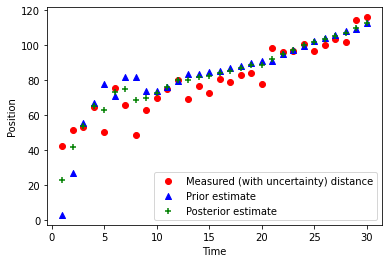

In [17]:
# Inspect
plot1 = plt.figure(1)
#plt.plot(time, pos_truth)
plt.scatter(time, pos_obs, color="red")
plt.ylabel('Position')
plt.xlabel('Time')
plt.scatter(time, mu_prior, color="blue", marker="^")
plt.scatter(time, mu_posterior, color="green", marker="+")
plt.legend([
    #'True distance', 
    'Measured (with uncertainty) distance', 
    'Prior estimate',
    'Posterior estimate'])
plt.show()